# Predicting Austrailian Rain

In [54]:
#import libraries and format output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import recall_score, accuracy_score, precision_score
pd.set_option('display.max_columns',150)
pd.set_option('display.max_rows',150)

In [3]:
#import clean and feature engineered dataset
import pickle

with open('df_modeling.pickle', 'rb') as handle:
    df_modeling = pickle.load(handle)

## Modeling

### KNN

In [4]:
X = df_modeling.drop(columns = ['Date','RainTomorrow'])
y = df_modeling['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 24)

In [8]:
#only scale non binary columns
base_ct = ColumnTransformer([
        ('base_transform', StandardScaler(), continuous_features)
    ], remainder='passthrough')

base_ct.fit(X_train)
X_train_base_scaled = pd.DataFrame(data=base_ct.transform(X_train), columns = X_train.columns, index = X_train.index)
X_test_base_scaled = pd.DataFrame(data=base_ct.transform(X_test), columns = X_test.columns, index = X_test.index)

In [74]:
scaled_pipeline_1 = Pipeline([('ct', ColumnTransformer([('base_transform', StandardScaler(), continuous_features)], remainder='passthrough')), 
                              ('knn', KNeighborsClassifier(n_jobs = -1)),],
                             verbose = True
                            )

In [75]:
# Fit the training data to pipeline
scaled_pipeline_1.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing ct, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing knn, total=   5.2s


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_transform',
                                                  StandardScaler(),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Rainfall', 'Evaporation',
                                                   'Sunshine', 'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Latitude', 'Longitude',
                                                   'Avg_Pressure'])])),
                ('knn', KNeighborsClassifier(n_jobs=-1))],
         verbose=True)

In [76]:
y_train_preds_base = scaled_pipeline_1.predict(X_train)
y_test_preds_base = scaled_pipeline_1.predict(X_test)

In [77]:
train_recall_base = recall_score(y_train, y_train_preds_base)
test_recall_base = recall_score(y_test, y_test_preds_base)
print(f'Training recall (base model): {train_recall_base}')
print(f'Test recall (base model): {test_recall_base}')

Training recall (base model): 0.6067851664711721
Test recall (base model): 0.4990731204943357


Our base model didn't preform that well. There's a lot of things that need to be optimized yet and we still
have a class imbalance. You can tell that we are overfiting to our data quite a bit. This is probably due to our class imbalance.

### LogReg DownSampling

In [156]:
from sklearn.utils import resample

#combine training x and y to one df
training = pd.concat([X_train_base_scaled, y_train], axis = 1)
# downsample majority
minority = training[training['RainTomorrow'] == 1]
majority = training[training['RainTomorrow'] == 0]
no_rain_downsampled = resample(majority,
                                replace = False, # sample without replacement
                                n_samples = len(minority), # match minority n
                                random_state = 23) # reproducible results

In [157]:
# combine minority and downsampled majority
downsampled = pd.concat([no_rain_downsampled, minority])

# checking counts
downsampled.RainTomorrow.value_counts()

1    22166
0    22166
Name: RainTomorrow, dtype: int64

In [158]:
from sklearn.linear_model import LogisticRegression
# trying logistic regression with downsampled dataset
y_train_downsampled = downsampled.RainTomorrow
X_train_downsampled = downsampled.drop(columns = 'RainTomorrow')


downsampled_lr = LogisticRegression(solver='liblinear')


downsampled_lr.fit(X_train_downsampled, y_train_downsampled)

downsampled_train_preds = downsampled_lr.predict(X_train_downsampled)

downsampled_test_preds = downsampled_lr.predict(X_test_base_scaled)

# checking recall
print('Training recall (downsampled LogReg): ', recall_score(y_train_downsampled, downsampled_train_preds))

# checking recall
print('Testing recall (downsampled LogReg): ', recall_score(y_test, downsampled_test_preds))

Training recall (downsampled LogReg):  0.781512225931607
Testing recall (downsampled LogReg):  0.7826982492276005


We can see that this clearly preformed way better. This is good. It is also not overfitting. Let's see if smote improves this.

### LogReg SMOTE

In [81]:
from imblearn.over_sampling import SMOTE

sm_base = SMOTE(random_state=55)
X_train_smote, y_train_smote = sm_base.fit_sample(X_train_base_scaled, y_train)

In [82]:
y_train_smote.value_counts()

1    77364
0    77364
Name: RainTomorrow, dtype: int64

In [83]:
# trying logistic regression with smote dataset
smote_lr = LogisticRegression(solver='liblinear')

smote_lr.fit(X_train_smote, y_train_smote)

smote_train_preds = smote_lr.predict(X_train_smote)

smote_test_preds = smote_lr.predict(X_test_base_scaled)

# checking recall
print('Training recall (SMOTE LogReg): ', recall_score(y_train_smote, smote_train_preds))

# checking recall
print('Testing recall (SMOTE LogReg): ', recall_score(y_test, smote_test_preds))

Training recall (SMOTE LogReg):  0.7877695051962152
Testing recall (SMOTE LogReg):  0.782389289392379


SMOTE was not necessarily and improvement. This model is close to the other one, but overfits a little bit. Let's see if a mixture of both will help

### LogReg SMOTE and DownSampling

In [84]:
no_rain_downsampled = resample(majority,
                                replace = False, # sample without replacement
                                n_samples = round((len(majority) - len(minority)) / 2) + len(minority), # match minority n
                                random_state = 23) # reproducible results

In [85]:
# combine minority and partly downsampled majority
partly_downsampled = pd.concat([no_rain_downsampled, minority])

# checking counts
partly_downsampled.RainTomorrow.value_counts()

0    49765
1    22166
Name: RainTomorrow, dtype: int64

In [86]:
y_train__partly_downsampled = partly_downsampled.RainTomorrow
X_train_partly_downsampled = partly_downsampled.drop(columns = 'RainTomorrow')

sm_mix = SMOTE(random_state=55)
X_train_mix, y_train_mix = sm_mix.fit_sample(X_train_partly_downsampled, y_train__partly_downsampled)

In [87]:
y_train_mix.value_counts()

1    49765
0    49765
Name: RainTomorrow, dtype: int64

In [88]:
mix_lr = LogisticRegression(solver='liblinear')

mix_lr.fit(X_train_mix, y_train_mix)

mix_train_preds = mix_lr.predict(X_train_mix)

mix_test_preds = mix_lr.predict(X_test_base_scaled)

# checking recall
print('Training recall (mix LogReg): ', recall_score(y_train_mix, mix_train_preds))

# checking recall
print('Testing recall (mix LogReg): ', recall_score(y_test, mix_test_preds))

Training recall (mix LogReg):  0.7862353059379081
Testing recall (mix LogReg):  0.7817713697219362


This still didn't perform as well as downsampling. We will try one last option.

### Balanced Class Weights

In [159]:
balanced_lr = LogisticRegression(solver='liblinear', class_weight='balanced')


balanced_lr.fit(X_train_base_scaled, y_train)

balanced_train_preds = balanced_lr.predict(X_train_base_scaled)

balanced_test_preds = balanced_lr.predict(X_test_base_scaled)

# checking recall
print('Training recall (balanced LogReg): ', recall_score(y_train, balanced_train_preds))

# checking recall
print('Testing recall (balanced LogReg): ', recall_score(y_test, balanced_test_preds))

Training recall (balanced LogReg):  0.7823693945682577
Testing recall (balanced LogReg):  0.7829042224510814


This is barely worse than the downsampled method and we get to utlize a lot more observations, so we are going to use this model in our grid search.

### Balanced LogReg with GridSearch

In [90]:
#define params
params = [{'penalty': ['l1'], 
         'C': [0.001, 0.01, 0.1, 1], 
         'max_iter': [100, 500],
         'warm_start': [True, False]
        }]

#initialize grid search
gridsearch_balanced_lr = GridSearchCV(estimator=balanced_lr, 
                                      param_grid=params, 
                                      scoring='recall', 
                                      cv=10,
                                      n_jobs = -1,
                                      verbose = 2
                                     )

In [91]:
gridsearch_balanced_lr.fit(X_train_base_scaled, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 29.4min finished


GridSearchCV(cv=10,
             estimator=LogisticRegression(class_weight='balanced',
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1], 'max_iter': [100, 500],
                          'penalty': ['l1'], 'warm_start': [True, False]}],
             scoring='recall', verbose=2)

In [100]:
gridsearch_balanced_lr.best_params_

{'C': 1, 'max_iter': 100, 'penalty': 'l1', 'warm_start': False}

In [101]:
gridsearch_balanced_lr.best_score_

0.7803847728986224

In [110]:
balanced_grid_lr_preds = gridsearch_balanced_lr.predict(X_test_base_scaled)

In [112]:
# checking recall
print('Training recall (balanced l1 gridsearch LogReg): ', gridsearch_balanced_lr.best_score_)

# checking recall
print('Testing recall (balanced l1 gridsearch LogReg): ', recall_score(y_test, balanced_grid_lr_preds))

Training recall (balanced l1 gridsearch LogReg):  0.7803847728986224
Testing recall (balanced l1 gridsearch LogReg):  0.7828012358393409


In [94]:
X_train_base_scaled.shape[1]

139

In [163]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=100)

selector.fit(X_train_base_scaled, y_train)

SelectKBest(k=100)

In [164]:
selected_columns = X_train_base_scaled.columns[selector.get_support()]
removed_columns = X_train_base_scaled.columns[~selector.get_support()]

In [160]:
#define params
params2 = [{'penalty': ['l2'], 
         'C': [0.1, 1], 
         'max_iter': [100, 500],
         'warm_start': [True, False]
        }]

#initialize grid search
gridsearch_balanced_lr2 = GridSearchCV(estimator=balanced_lr, 
                                      param_grid=params2, 
                                      scoring='recall', 
                                      cv=10,
                                      n_jobs = -1,
                                      verbose = 2
                                     )

In [165]:
gridsearch_balanced_lr2.fit(X_train_base_scaled[selected_columns], y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   39.8s finished


GridSearchCV(cv=10,
             estimator=LogisticRegression(class_weight='balanced',
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid=[{'C': [0.1, 1], 'max_iter': [100, 500],
                          'penalty': ['l2'], 'warm_start': [True, False]}],
             scoring='recall', verbose=2)

In [166]:
gridsearch_balanced_lr2.best_params_

{'C': 1, 'max_iter': 100, 'penalty': 'l2', 'warm_start': True}

In [167]:
gridsearch_balanced_lr2.best_score_

0.7789411977352555

In [168]:
balanced_grid_lr2_preds = gridsearch_balanced_lr2.predict(X_test_base_scaled[selected_columns])

In [169]:
# checking recall
print('Training recall (balanced l1 gridsearch LogReg): ', gridsearch_balanced_lr2.best_score_)

# checking recall
print('Testing recall (balanced l1 gridsearch LogReg): ', recall_score(y_test, balanced_grid_lr2_preds))

Training recall (balanced l1 gridsearch LogReg):  0.7789411977352555
Testing recall (balanced l1 gridsearch LogReg):  0.7833161688980432


Grid search helped improve our logistic regressor slightly! Let's see if other types of models can improve our prediciton

### Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

rand_for = RandomForestClassifier(random_state=30)

In [14]:
#define params
params_rand_for = [{'max_depth': range(1,11), 
         'min_samples_leaf': range(5,30,5), 
         'max_features': range(10,110,20),
         'oob_score': [True, False],
         'warm_start': [True],
         'max_leaf_nodes': range(5,50,10)
        }]

#initialize grid search
gridsearch_rand_for = GridSearchCV(estimator=rand_for, 
                                      param_grid=params_rand_for, 
                                      scoring='recall', 
                                      cv=5,
                                      n_jobs = -1,
                                      verbose = 2
                                     )

In [15]:
gridsearch_rand_for.fit(X_train, y_train)

Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 42.6min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 57.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 81.8min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 117.6min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 150.6min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 197.5min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 256.7min
[Parallel(n_jobs=-1)]: Done 9097 tasks     

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=30), n_jobs=-1,
             param_grid=[{'max_depth': range(1, 11),
                          'max_features': range(10, 110, 20),
                          'max_leaf_nodes': range(5, 50, 10),
                          'min_samples_leaf': range(5, 30, 5),
                          'oob_score': [True, False], 'warm_start': [True]}],
             scoring='recall', verbose=2)

In [16]:
gridsearch_rand_for.best_params_

{'max_depth': 8,
 'max_features': 90,
 'max_leaf_nodes': 45,
 'min_samples_leaf': 5,
 'oob_score': True,
 'warm_start': True}

In [17]:
gridsearch_rand_for.best_score_

0.44581797791016875

In [19]:
rand_for_grid_preds = gridsearch_rand_for.predict(X_test)

In [27]:
# checking recall
print('Training recall (random forest gridsearch): ', gridsearch_rand_for.best_score_)

# checking recall
print('Testing recall (random forest gridsearch): ', recall_score(y_test, rand_for_grid_preds))

Training recall (random forest gridsearch):  0.44581797791016875
Testing recall (random forest gridsearch):  0.4558187435633368


Random forest is not doing a good job at predicting. Maybe a simpler decision tree will be better

### Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier

In [31]:
tree = DecisionTreeClassifier(random_state = 42)
tree.fit(X_train_base_scaled, y_train)

DecisionTreeClassifier(random_state=42)

In [32]:
tree_train_preds = tree.predict(X_train_base_scaled)
tree_test_preds = tree.predict(X_test_base_scaled)

In [33]:
# checking recall
print('Training recall (decision tree): ', recall_score(y_train, tree_train_preds))

# checking recall
print('Testing recall (decision tree): ', recall_score(y_test, tree_test_preds))

Training recall (decision tree):  1.0
Testing recall (decision tree):  0.5462409886714727


It is way overfit, so lets tune some hyperparams

In [29]:
#define params
params_tree = [{'max_depth': range(1,11), 
         'min_samples_leaf': range(1,30,5), 
         'max_features': range(10,110,20),
         'max_leaf_nodes': range(5,50,10)
        }]

#initialize grid search
gridsearch_tree = GridSearchCV(estimator=tree, 
                                      param_grid=params_tree, 
                                      scoring='recall', 
                                      cv=5,
                                      n_jobs = -1,
                                      verbose = 2
                                     )

In [34]:
gridsearch_tree.fit(X_train_base_scaled,y_train)

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:  6.8min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid=[{'max_depth': range(1, 11),
                          'max_features': range(10, 110, 20),
                          'max_leaf_nodes': range(5, 50, 10),
                          'min_samples_leaf': range(1, 30, 5)}],
             scoring='recall', verbose=2)

In [35]:
gridsearch_tree.best_params_

{'max_depth': 1,
 'max_features': 90,
 'max_leaf_nodes': 5,
 'min_samples_leaf': 1}

In [36]:
gridsearch_tree.best_score_

0.45894604180867227

It appears that decision trees are having a difficulty with this classification. Let's see if XGBoost can do any better.

### XGBOOST

In [40]:
import xgboost as xgb

In [61]:
D_train = xgb.DMatrix(X_train, label = y_train)
D_test = xgb.DMatrix(X_test, label = y_test)

In [62]:
param_xg = {
             'eta': 0.3,
             'max_depth': 3,
             'objective': 'binary:hinge',#'binary:logistic',
}

steps = 20

In [63]:
xgboost = xgb.train(params = param_xg, dtrain = D_train, num_boost_round=steps)

In [64]:
xgboost_train_preds = xgboost.predict(D_train)
xgboost_test_preds = xgboost.predict(D_test)

In [66]:
# checking recall
print('Training recall (xgboost): ', recall_score(y_train, xgboost_train_preds))

# checking recall
print('Testing recall (xgboost): ', recall_score(y_test, xgboost_test_preds))

Training recall (xgboost):  0.4461788324460886
Testing recall (xgboost):  0.4537590113285273


XGBoost isn't performing well either, perhaps this is an issue of multicollinearity. Let's get rid of some features and see how it performs.

### XGBOOST with feature selection

In [143]:
from sklearn.feature_selection import SelectKBest, f_classif
selector2 = SelectKBest(f_classif, k=60)

selector2.fit(X_train, y_train)

SelectKBest(k=60)

In [144]:
selected_columns2 = X_train_base_scaled.columns[selector2.get_support()]
removed_columns2 = X_train_base_scaled.columns[~selector2.get_support()]

In [145]:
selected_columns2

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Latitude', 'Avg_Pressure', 'Location_ALBANY',
       'Location_ALICE SPRINGS AIRPORT', 'Location_CAIRNS AERO',
       'Location_COBAR AIRPORT AWS', 'Location_DARTMOOR',
       'Location_MILDURA AIRPORT', 'Location_MOREE AERO',
       'Location_MOUNT GAMBIER AERO', 'Location_NORFOLK ISLAND AERO',
       'Location_NORTH WALPOLE', 'Location_PORTLAND (CASHMORE AIRPORT)',
       'Location_ULURU', 'Location_WOOMERA AERODROME', 'WindGustDir_ENE',
       'WindGustDir_ESE', 'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_W',
       'WindGustDir_WNW', 'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NNE',
       'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_SE', 'WindDir9am_SSE',
       'WindDir3pm_ESE', 'WindDir3pm_N', 'WindDir3pm_NNW', 'WindDir3pm_NW',
       'WindDir3pm_WNW', 'Cloud9am_1', 'Cloud9am_2', 'Cloud9am_3',
       'Cloud9am

In [146]:
D_train_reduced = xgb.DMatrix(X_train[selected_columns2], label = y_train)
D_test_reduced = xgb.DMatrix(X_test[selected_columns2], label = y_test)

In [147]:
param_xg_reduced = {
             'eta': 0.1,
             'max_depth': 10,
             'objective': 'binary:hinge',#'binary:logistic',
             'eval_metric': 'map'
}

steps_reduced = 20

In [148]:
xgboost_reduced = xgb.train(params = param_xg_reduced, dtrain = D_train_reduced, num_boost_round=steps_reduced)

In [149]:
xgboost_reduced_train_preds = xgboost_reduced.predict(D_train_reduced)
xgboost_reduced_test_preds = xgboost_reduced.predict(D_test_reduced)

# checking recall
print('Training recall (xgboost): ', recall_score(y_train, xgboost_reduced_train_preds))

# checking recall
print('Testing recall (xgboost): ', recall_score(y_test, xgboost_reduced_test_preds))

Training recall (xgboost):  0.7027880537760535
Testing recall (xgboost):  0.6129763130792997


It still doesn't perform as well as the logistic regression. Tree based regressors are having trouble prediciting from this dataset. I think this is because the tree based regressors can't split on location in a significant way. The data is evenly distributed between the different weather stations. Consequently, we will use logistic regession for our final model.

---

## Final Model

### Scores

In [280]:
print('Testing recall (balanced l1 gridsearch LogReg): ', recall_score(y_test, balanced_grid_lr2_preds))
print('Testing accuracy (balanced l1 gridsearch LogReg): ', accuracy_score(y_test, balanced_grid_lr2_preds))
print('Testing precision (balanced l1 gridsearch LogReg): ', precision_score(y_test, balanced_grid_lr2_preds))

Testing recall (balanced l1 gridsearch LogReg):  0.7833161688980432
Testing accuracy (balanced l1 gridsearch LogReg):  0.7936563752725226
Testing precision (balanced l1 gridsearch LogReg):  0.5317393736017897


These are the metrics of the final model. As you can see since we prioritized recall, our precision suffered.

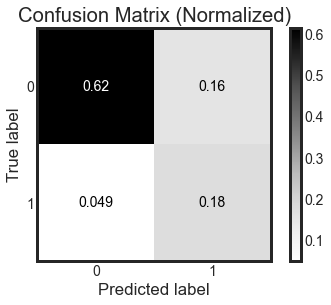

In [275]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(gridsearch_balanced_lr2.best_estimator_, X_test_base_scaled[selected_columns], y_test, cmap = 'Greys', normalize='all')
plt.title('Confusion Matrix (Normalized)')
plt.savefig('confusion_matrix.png', bbox = 'tight')

This is even more apparent in the confusion matrix. We had a false positive 16% of the time compared to a false positive 5% of the time.

### Interpretation

In [244]:
coef_df = pd.DataFrame(list(zip(selected_columns,gridsearch_balanced_lr2.best_estimator_.coef_[0])), columns = ['Feature', 'Coefficient'])

In [245]:
coef_df['coef_abs'] = coef_df['Coefficient'].apply(lambda x: abs(x))
coef_df['positive'] = coef_df['Coefficient'] > 0
coef_df.set_index('Feature', inplace = True)

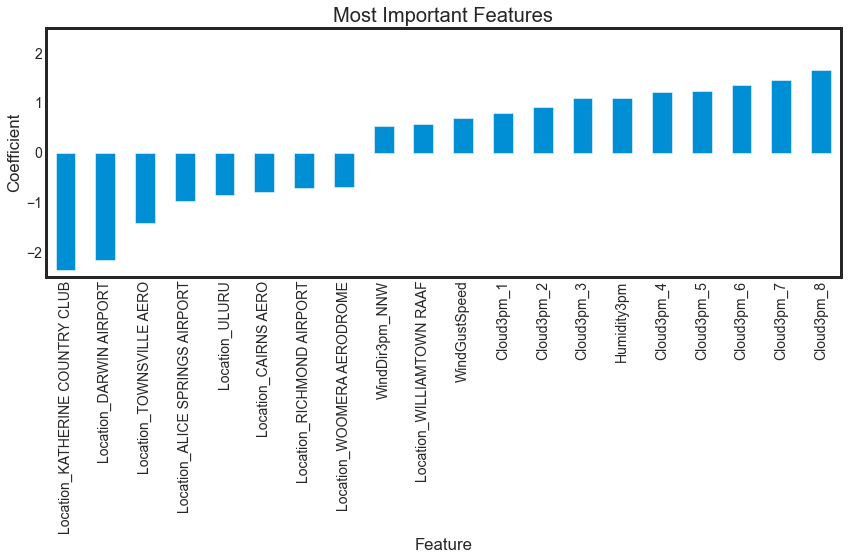

In [266]:
plt.style.use('fivethirtyeight')
sns.set_style('white')
fig, ax = plt.subplots(figsize = (12,8))
coef_df.sort_values(by = 'coef_abs', ascending = False).head(20).sort_values(by = 'Coefficient')['Coefficient'].plot(kind = 'bar', ax = ax)
ax.set_ylim(-2.5,2.5)
ax.set_title('Most Important Features')
ax.set_ylabel('Coefficient')
ax.set_xlabel('Feature')
plt.tight_layout()
fig.savefig('most_important_features.png', bbox = 'tight')

Cloud cover at 3pm, wind direction, and location are important features to prediction. Let's see why those locations were negatively correlated to rain tomorrow.

In [263]:
important_feature_location = {                           
 'RICHMOND AIRPORT': {'Lat': -20.7017, 'Lon': 143.1167},                   
 'WILLIAMTOWN RAAF': {'Lat': -32.7939, 'Lon': 151.8364},                         
 'CAIRNS AERO': {'Lat': -16.8736, 'Lon': 145.7458},
 'TOWNSVILLE AERO': {'Lat': -19.2483, 'Lon': 146.7661},                              
 'WOOMERA AERODROME': {'Lat': -31.1558, 'Lon': 136.8054},
 'ALICE SPRINGS AIRPORT': {'Lat': -23.7951, 'Lon': 133.889},
 'DARWIN AIRPORT': {'Lat': -12.4239, 'Lon': 130.8925},                        
 'KATHERINE COUNTRY CLUB': {'Lat': -14.4728, 'Lon': 132.2612},
 'ULURU': {'Lat': -25.3444, 'Lon': 131.0369}}

In [281]:
m2=folium.Map(location=[-25.2744, 133.7751],tiles='cartodbpositron',zoom_start=4)


# Adding Custom Markers
for key, value in important_feature_location.items():
    folium.Marker(location=[value['Lat'], value['Lon']],popup=f'Lat:{value["Lat"]} Lon:{value["Lon"]}',tooltip=key,icon=folium.Icon(color='blue',icon='none')).add_to(m2)

m2

With exception to the south east weather station, the locations that are negatively correlated are father inland or more protected from the open water. Especially, when paired with wind direction in the NNW direction being a strong predictor of rain. Consequently, storms most likely come from the SSE direction and most of the negatively correlated locations are situated in the opposite side of Austrailia away from where the storms come in.

## Conclusion

Based on the analysis, I recommend including a predictive feature in residential irrigation systems. The final model could reduce ~80% of wasted water from watering before it rains. It would be better to market the product toward conservation/environment focused consumers. The model would only save consumers ~$150 annually. Conequently, I believe the water conservation would be a bigger draw for customers rather than the financial benefits.

Finally, I recommend approaching city officials to make rain prediction required on all irrigation systems. This would increase the impact of water conservation and benefit cities as whole.

## Further Steps

Some additional steps I would like to explore are as follows:

-Build model for residential use<br>
-Predict farther in the future<br>
-Utilize ‘neighboring’ predictions in a pseudo voting classifier model